In [1]:
from pathlib import Path
import math
import copy
import pdb

In [2]:
Path.ls = lambda x: list(x.iterdir())

In [3]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import torch

In [5]:
!git clone https://github.com/azfarkhoja305/Handwritten-Sequence-RNNs.git

fatal: destination path 'Handwritten-Sequence-RNNs' already exists and is not an empty directory.


In [5]:
# Load data
data_path = Path('./Handwritten-Sequence-RNNs/data')
strokes = np.load(data_path/'strokes-py3.npy', allow_pickle=True)
with open(data_path/'sentences.txt') as f:
    texts = f.readlines()

In [6]:
# Sanity check
len(strokes), len(texts)

(6000, 6000)

In [7]:
# function to plot a single stroke
def plot_stroke(stroke, label=None):
    x,y = np.cumsum(stroke[:,1]), np.cumsum(stroke[:,2])
    x_len = x.max() - x.min()
    y_len = y.max() - y.min()
    plt.figure(figsize=(2*x_len/y_len,3))
    pen_lifts = np.flatnonzero(stroke[:,0])
    begin = 0
    for idx in pen_lifts:
        plt.plot(x[begin:idx],y[begin:idx], 'k')
        begin = idx + 1
    if label is not None:
        plt.title(label,fontsize=15) 
    plt.tight_layout()
    plt.axis('off')
    plt.show()

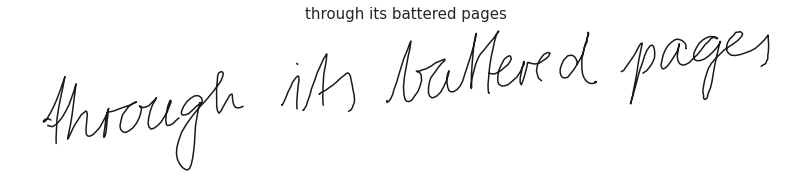

In [8]:
# Plot Strokes
idx = -1
plot_stroke(strokes[idx],texts[idx])

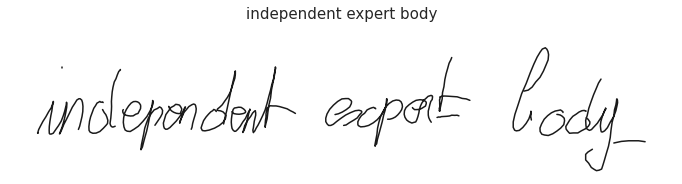

In [9]:
idx = 17
plot_stroke(strokes[idx],texts[idx])

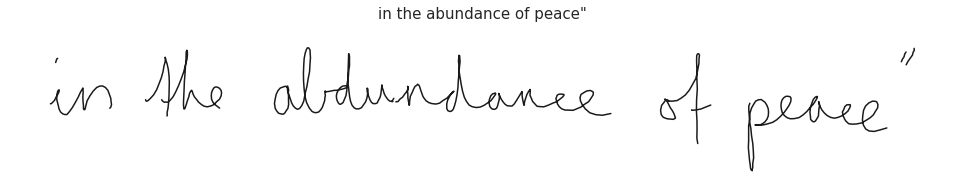

In [10]:
idx = 0
plot_stroke(strokes[idx],texts[idx])

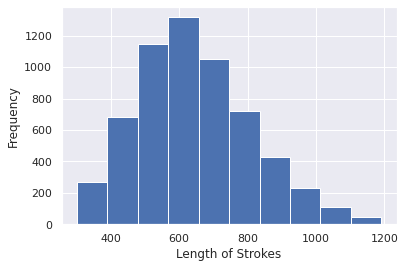

In [11]:
# histogram of sequence lengths
lengths = [len(s) for s in strokes]
plt.hist(lengths,bins=10)
plt.ylabel('Frequency')
plt.xlabel("Length of Strokes")
plt.show()

In [12]:
# Check need for normalization, already in nomalized format
all_x =np.array([x for s in strokes for x in s[:,1]])
all_y =np.array([y for s in strokes for y in s[:,2]])
print(f"X coord -> Mean: {all_x.mean()} STD: {all_x.std()} ")
print(f"Y coord -> Mean: {all_y.mean()} STD: {all_y.std()} ")

X coord -> Mean: 0.41248124837875366 STD: 2.0786476135253906 
Y coord -> Mean: -0.006003160960972309 STD: 1.8560572862625122 


In [13]:
# # ADD start token
# START=[[3,0,0]]
# def add_start(strokes):
#     new_strokes = copy.deepcopy(strokes)
#     for i in range(len(strokes)):
#         new_strokes[i] = np.r_[START,new_strokes[i]].astype(np.float32)
#     return new_strokes

In [14]:
final_strokes = copy.deepcopy(strokes)

In [15]:
# Split last 10 % as validation
split = int(0.1*len(strokes))
train_strokes = final_strokes[:-split]
valid_strokes = final_strokes[-split:]
print(f"Length Train Set: {len(train_strokes)}")
print(f"Length Val Set: {len(valid_strokes)}")

Length Train Set: 5400
Length Val Set: 600


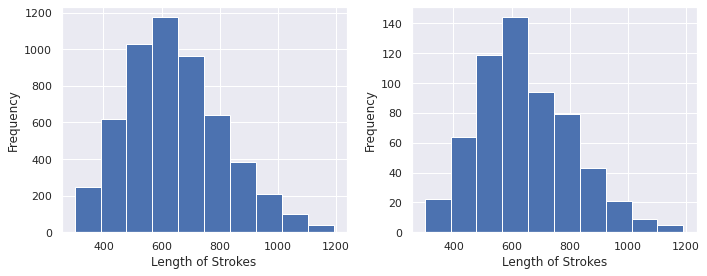

In [16]:
# Sanity check train and valid data have similar distributions
train_lens = [len(s) for s in train_strokes]
valid_lens = [len(s) for s in valid_strokes]
_,axs = plt.subplots(1,2, figsize=(10,4), sharex=True)
axs[0].hist(train_lens)
axs[1].hist(valid_lens)
plt.setp(axs[:], xlabel="Length of Strokes")
plt.setp(axs[:], ylabel='Frequency')
plt.tight_layout()
plt.show()

In [17]:
PAD = [[2,0,0]]
shuffle_bucket = lambda bucket: np.random.permutation(bucket)

In [18]:
# Smarter way to shuffle as random shuffling leads to a lot of padding
def get_buckets(strokes,batch_sz,buffer):
    # Sort acc to length
    strokes = sorted(strokes, key= lambda x:len(x))
    # Divide the data into buckets of size batch_sz*buffer
    total_buckets = math.ceil(len(strokes)/(batch_sz*buffer))
    all_buckets = []
    for i in range(total_buckets):
        one_bucket = strokes[i*batch_sz*buffer : (i+1)*batch_sz*buffer]
        # Fix seq_len of a bucket by padding samples
        seq_len = max([len(s) for s in one_bucket])
        for j in range(len(one_bucket)): # len of last bucket can be different
            diff = seq_len - len(one_bucket[j])
            if diff != 0:
                pad = np.array(PAD*diff)
                one_bucket[j] = np.r_[one_bucket[j],pad].astype(np.float32)

        all_buckets.append(np.stack(one_bucket))
    return all_buckets

In [19]:
def get_xy(batch,bptt,sig):
    seq_len = batch.shape[1]
    # x.shape[1] != y.shape[1] for the last sequence
    # hence use seq_len-1 below 
    total_seq = (seq_len-1) // bptt
    x_seqs, y_seqs = [],[]
    for k in range(total_seq):
        x = batch[:, k*bptt : (k+1)*bptt]
        y = batch[:, k*bptt+1 : (k+1)*bptt+1]
        x_seqs.append(x), y_seqs.append(y)
    # Get last sequence only if significant (> sig*bptt)
    rem = (seq_len-1)%bptt
    if rem > sig*bptt:
        x = batch[:, (k+1)*bptt : -1]
        y = batch[:, (k+1)*bptt+1 :]
        x_seqs.append(x), y_seqs.append(y)
    return x_seqs, y_seqs

In [20]:
# Shuffle buckets and yield batches
def batch_loader(all_buckets, batch_sz, max_bptt=300, sig=0):
    for bucket in all_buckets:
        bucket = shuffle_bucket(bucket)
        num_bucket_batches = math.ceil(len(bucket)/batch_sz)
        for i in range(num_bucket_batches):
            # Get one batch from bucket
            batch = bucket[i*batch_sz : (i+1)*batch_sz]
            new_batch = True 
            x_seqs, y_seqs = get_xy(batch, max_bptt, sig)
            for x,y in zip(x_seqs, y_seqs):
                yield x, y, new_batch
                new_batch = False

In [21]:
def check_gpu():
    if torch.cuda.is_available(): device = torch.device('cuda')
    else: device = torch.device('cpu')
    return device

In [22]:
batch_sz = 356
bucket_scale = 2
bptt = 350
# get buckets
train_buckets = get_buckets(train_strokes, batch_sz, bucket_scale)
valid_buckets = get_buckets(valid_strokes, int(batch_sz*1.5), bucket_scale)
# dataloaders
train_loader = lambda: batch_loader(train_buckets, batch_sz, max_bptt=bptt, sig=0.2)
valid_loader = lambda: batch_loader(valid_buckets, int(batch_sz*1.5), max_bptt=bptt)
device = check_gpu()

In [23]:
# sanity check
for x,y,new_batch in valid_loader():
    print("NEW BATCH:", new_batch)
    print(y.shape)

NEW BATCH: True
(534, 250, 3)
NEW BATCH: False
(534, 250, 3)
NEW BATCH: False
(534, 250, 3)
NEW BATCH: False
(534, 250, 3)
NEW BATCH: False
(534, 189, 3)
NEW BATCH: True
(66, 250, 3)
NEW BATCH: False
(66, 250, 3)
NEW BATCH: False
(66, 250, 3)
NEW BATCH: False
(66, 250, 3)
NEW BATCH: False
(66, 189, 3)


In [24]:
# Start defining models
import torch.nn as nn
## Credit https://github.com/fastai/fastai/blob/master/fastai/layers.py#L285

def trunc_normal_(x, mean:float=0., std:float=1.):
    "Truncated normal initialization."
    return x.normal_().fmod_(2).mul_(std).add_(mean)

def embedding(ni,nf,padding_idx=None):
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf, padding_idx)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb

In [25]:
class InLayer(nn.Module):
    def __init__(self,embed_dims=5,fc_size=10):
        super().__init__()
        # 0,1,pad
        self.embed = embedding(3,embed_dims, padding_idx=2)
        self.fc1 = nn.Linear(2,embed_dims)
        self.fc2 = nn.Linear(2*embed_dims,fc_size)
        self.activation = nn.ReLU()
    def forward(self,x):
        ordinal, real = x[...,0].long(), x[...,1:]
        ordinal = self.embed(ordinal)
        real = self.fc1(real)
        final = self.fc2(torch.cat([ordinal,real],2))
        return self.activation(final) 

In [26]:
class RecurLayer(nn.Module):
    def __init__(self,ip_dims=10,num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.rnns = nn.ModuleList([nn.LSTM(ip_dims,ip_dims,batch_first=True)])
        for i in range (num_layers-1):
            self.rnns.append(nn.LSTM(ip_dims*2,ip_dims,batch_first=True))
    def forward(self,x,prev_state=None):
        if prev_state == None:
            prev_state = [None]*self.num_layers
        cat_xs, new_state = [], []
        skip_x = x.clone()
        for i in range(self.num_layers):
            new_x,s = self.rnns[i](x,prev_state[i])
            cat_xs.append(new_x), new_state.append(s)
            x = torch.cat([skip_x,new_x],2) # skip connection inputs
        return torch.cat(cat_xs, 2), new_state # outputs from all layers

In [27]:
class MixtureDensity(nn.Module):
    def __init__(self,ip_dims,num):
        super().__init__()
        self.num = num
        self.ce = nn.Linear(ip_dims,3)
        self.pi = nn.Linear(ip_dims,num)
        self.sigma = nn.Linear(ip_dims,num*2)
        self.rho = nn.Linear(ip_dims,num)
        self.mu = nn.Linear(ip_dims,num*2)
    def forward(self,x):
        ce = self.ce(x)
        pi = self.pi(x)
        rho = self.rho(x)
        shape = x.size()
        sigma = self.sigma(x).view(shape[0],shape[1],self.num,2)
        mu = self.mu(x).view(shape[0],shape[1],self.num,2)
        return ce,pi,rho,sigma,mu

In [28]:
class FinalActivation(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.LogSoftmax(dim=-1)
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()
    def forward(self,ce,pi,rho,sigma,mu):
        pi = self.softmax(pi)
        rho = self.tanh(rho)
        sigma = self.softplus(sigma)
        return ce,pi,rho,sigma,mu

In [29]:
class AutoGen(nn.Module):
    def __init__(self,fc_size=20,rnn_layers=2,n_g=20):
        super().__init__()
        self.inlayer = InLayer(fc_size = fc_size)
        self.recurlayer = RecurLayer(fc_size,rnn_layers)
        self.outlayer = MixtureDensity(rnn_layers*fc_size,n_g)
        self.activation = FinalActivation()
    def forward(self,x,prev_state):
        x = self.inlayer(x)
        x,new_state = self.recurlayer(x,prev_state)
        params = self.outlayer(x)
        params = self.activation(*params)
        return params, tuple(new_state)

In [30]:
for x,y,new_batch in train_loader(): break
x,y = torch.as_tensor(x), torch.as_tensor(y)
if new_batch: prev_state = None
else: prev_state = repackage_hidden(prev_state)
model = AutoGen()
(ce,pi,rho,sigma,mu),_ = model(x, prev_state)
preds, _ = model(x, prev_state) 

In [33]:
def get_probs(target,rho,sigma,mu):
    # better stability
    eps = 1e-6
    rho = rho/(1+eps)
    sigma = sigma + eps
    const_pi = torch.as_tensor(np.pi, device=mu.device)

    diff = target.unsqueeze(-2).expand_as(mu) - mu
    Z = torch.sum(diff**2/(sigma**2), -1) - \
                    2*rho*diff.prod(-1)/(sigma.prod(-1))
    exp_terms = -Z/(2*(1-rho**2))
    log_terms = (2*const_pi).log() + (sigma[...,0]).log() + \
                    (sigma[...,1]).log() + 0.5*(1-rho**2).log()
    ans = -log_terms + exp_terms
    return  ans

In [34]:
class LossMetric():
    def __init__(self):
        self.loss_ce = nn.CrossEntropyLoss(reduction='none')
        self.total_celoss = 0
        self.total_nllloss = 0
        self.total_samples = 0
    def mask_loss(self,preds,y_true):
        # Mask pad tokens
        intrp,coords = y_true[:,:,0].long(), y_true[:,:,1:]
        mask = (~(intrp==2)).float()
        ce_preds,pi = preds[:2]
        ce_preds = ce_preds.transpose(-1,1)
        ce = self.loss_ce(ce_preds, intrp)
        ce = mask*ce

        probs = pi + get_probs(coords,*preds[2:])
        nll = -mask*(probs.logsumexp(-1))
        return ce.sum(), nll.sum(), mask.sum()
    def update_state(self, ce, nll, num):
        ce,nll,num = ce.item(), nll.item(), num.item()
        self.total_nllloss += nll
        self.total_celoss += ce
        self.total_samples += num
    def get_loss(self,preds,y_true):
        ce, nll, mask = self.mask_loss(preds,y_true)
        self.update_state(ce.clone().detach(),nll.clone().detach(),
                          mask.clone().detach())
        return (ce + nll)/mask
    def result(self):
        ce = self.total_celoss/ self.total_samples
        nll = self.total_nllloss/ self.total_samples
        return ce,nll, ce+nll
    def reset_state(self):
        self.total_celoss = 0
        self.total_nllloss = 0
        self.total_samples = 0

In [35]:
# track metrics for the entire epochs
train_metric = LossMetric()
valid_metric = LossMetric()

In [36]:
# detach hidden states to prevent backprop through the entire sequence
def repackage_hidden(prev_state):
    if isinstance(prev_state,torch.Tensor):
        return prev_state.detach()
    else:
        return tuple(repackage_hidden(h) for h in prev_state)

In [37]:
def train_epoch(model,train_loader,clip_norm,opt,scheduler=None):
    model.train()
    train_metric.reset_state()
    for i,(x,y,new_batch) in enumerate(train_loader()):
        x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
        if new_batch: prev_state = None
        else: prev_state = repackage_hidden(prev_state)
        params,prev_state = model(x, prev_state)
        loss = train_metric.get_loss(params,y)
        model.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),clip_norm)
        opt.step()
        if scheduler: scheduler.step()

In [38]:
def valid_epoch(model,valid_loader):
    model.eval()
    valid_metric.reset_state()
    with torch.no_grad():
        for x,y,new_batch in valid_loader():
            x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
            if new_batch: prev_state = None
            else: prev_state = repackage_hidden(prev_state)
            params,prev_state = model(x, prev_state)    
            _ = valid_metric.get_loss(params,y)

In [39]:
def plot_lr_find(lr_list,loss_list,skip=0):
    size = len(loss_list) - skip 
    plt.plot(lr_list[:size],loss_list[:size])
    plt.xscale('log')
    plt.show()

In [40]:
#https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
def lr_find(model,opt,clip,init_pow=-7,final_pow=0,beta=0.95,max_iters=200):
    model.train()
    lr_list = np.logspace(init_pow,final_pow,max_iters)
    avg_loss,batch_num = 0,0
    best_loss = float('inf')
    loss_list = []
    while batch_num<max_iters:
        for x,y,new_batch in train_loader():
            batch_num+=1
            x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
            if new_batch: prev_state = None
            else: prev_state = repackage_hidden(prev_state)
            params,prev_state = model(x, prev_state)
            loss = train_metric.get_loss(params,y)
            avg_loss = beta*avg_loss + (1-beta)*loss.item()
            smooth_loss = avg_loss / (1-beta**batch_num)
            if best_loss >= 0: 
                if smooth_loss > 5*best_loss: return lr_list,loss_list
            else: 
                if smooth_loss > best_loss/6: return lr_list,loss_list
            if smooth_loss < best_loss: best_loss = smooth_loss
            loss_list.append(smooth_loss)
            model.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),clip)
            for group in opt.param_groups: group['lr'] = lr_list[batch_num-1]
            opt.step()
            if batch_num >=max_iters: return lr_list,loss_list
    return lr_list,loss_list

In [41]:
import itertools
from torch import optim
def fit(model,epochs=20,max_lr=1e-3,clip=1,wd=0,find_lr=False):
    model = copy.deepcopy(model).to(device)
    epoch_steps = sum([1 for _ in train_loader()])
    # separate out rnn layers =>  wd = 0
    other_params = [p.parameters() for p in model.children() if p != model.recurlayer]
    opt = optim.AdamW([{'params':model.recurlayer.parameters(),'weight_decay':0},
                       {'params':itertools.chain(*other_params)}],
                       lr = max_lr,weight_decay = wd, betas= [0.95,0.999])
    if find_lr:
        lr_list,loss_list = lr_find(model,opt,clip,-6,0,max_iters=200)
        return lr_list, loss_list

    scheduler = optim.lr_scheduler.OneCycleLR(opt,max_lr,epochs=epochs,
                                  steps_per_epoch=epoch_steps)
    train_logs = {'ce_tl':[],'nll_tl':[],'tot_tl':[],'ce_vl':[],'nll_vl':[],'tot_vl':[]}
    best_valid_loss = float('inf')
    for e in tqdm(range(epochs)):
        train_epoch(model,train_loader,clip,opt,scheduler)
        valid_epoch(model,valid_loader)
        # order => ce, nll, tot
        all_metrics = train_metric.result() + valid_metric.result()
        if  all_metrics[-1] < best_valid_loss:
            best_valid_loss = all_metrics[-1]
            best_model = copy.deepcopy(model)
            
        if e%5 == 0 or e == epochs-1:
            tqdm.write(f'\nEpoch: {e}  Train Loss: {all_metrics[2]:.4f}  Valid Loss: {all_metrics[-1]:.4f}    Best Valid:{best_valid_loss:.4f}') 
        
        for log,value in zip(train_logs,all_metrics):
            train_logs[log].append(value)

    return best_model.to(device), train_logs

In [42]:
model = AutoGen(fc_size=20,rnn_layers=3,n_g=20)

In [55]:
lr_list,loss_list= fit(model,find_lr=True)

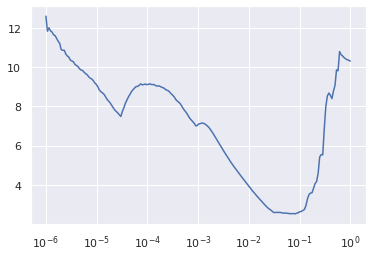

In [56]:
plot_lr_find(lr_list,loss_list)

In [43]:
model,logs = fit(model,200,1e-2,clip=1)


Epoch: 0  Train Loss: 7.8826  Valid Loss: 5.6609    Best Valid:5.6609

Epoch: 5  Train Loss: 2.0501  Valid Loss: 1.9191    Best Valid:1.9191

Epoch: 10  Train Loss: 1.0451  Valid Loss: 0.9823    Best Valid:0.9823

Epoch: 15  Train Loss: 0.7274  Valid Loss: 0.7727    Best Valid:0.7676

Epoch: 20  Train Loss: 0.5467  Valid Loss: 0.6100    Best Valid:0.5915

Epoch: 25  Train Loss: 0.4669  Valid Loss: 0.5118    Best Valid:0.5118

Epoch: 30  Train Loss: 0.4237  Valid Loss: 0.4604    Best Valid:0.4580

Epoch: 35  Train Loss: 0.4050  Valid Loss: 0.4549    Best Valid:0.4157

Epoch: 40  Train Loss: 0.3661  Valid Loss: 0.3996    Best Valid:0.3976

Epoch: 45  Train Loss: 0.3822  Valid Loss: 0.4391    Best Valid:0.3494

Epoch: 50  Train Loss: 0.3566  Valid Loss: 0.5900    Best Valid:0.3494

Epoch: 55  Train Loss: 0.3292  Valid Loss: 0.3932    Best Valid:0.3492

Epoch: 60  Train Loss: 0.3420  Valid Loss: 0.3617    Best Valid:0.2722

Epoch: 65  Train Loss: 0.2558  Valid Loss: 0.2899    Best Valid:0

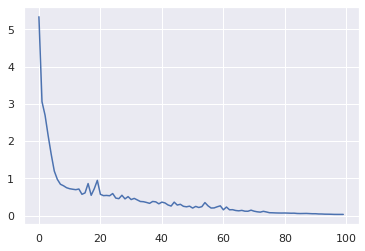

In [58]:
plt.plot(logs['tot_vl'])

In [59]:
lr_list,loss_list= fit(model,find_lr=True)

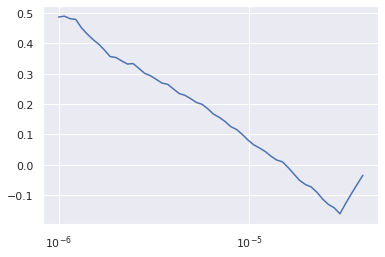

In [63]:
plot_lr_find(lr_list,loss_list)

In [64]:
model,logs = fit(model,50,1e-5,clip=1)


Epoch: 0  Train Loss: 0.0508  Valid Loss: 0.0313    Best Valid:0.0313

Epoch: 5  Train Loss: 0.0508  Valid Loss: 0.0313    Best Valid:0.0313

Epoch: 10  Train Loss: 0.0508  Valid Loss: 0.0313    Best Valid:0.0313

Epoch: 15  Train Loss: 0.0508  Valid Loss: 0.0311    Best Valid:0.0311

Epoch: 20  Train Loss: 0.0505  Valid Loss: 0.0310    Best Valid:0.0310

Epoch: 25  Train Loss: 0.0503  Valid Loss: 0.0308    Best Valid:0.0308

Epoch: 30  Train Loss: 0.0501  Valid Loss: 0.0306    Best Valid:0.0306

Epoch: 35  Train Loss: 0.0499  Valid Loss: 0.0305    Best Valid:0.0304

Epoch: 40  Train Loss: 0.0498  Valid Loss: 0.0304    Best Valid:0.0304

Epoch: 45  Train Loss: 0.0498  Valid Loss: 0.0304    Best Valid:0.0304

Epoch: 49  Train Loss: 0.0498  Valid Loss: 0.0304    Best Valid:0.0304



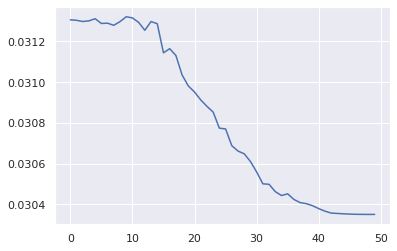

In [65]:
plt.plot(logs['tot_vl'])

In [66]:
from torch.distributions import Categorical, MultivariateNormal
# Sampling 
def ce_sample(ce,temp=1):
    ces = Categorical(logits=ce/temp).sample().data
    return ces.float()

def bivariate_sample(pi,rho,sigma,mu):
    """Sample from a mixture of bivariate gaussians"""
    pi,rho,sigma,mu = pi.squeeze(),rho.squeeze(),sigma.squeeze(),mu.squeeze()
    pis = Categorical(probs=pi.exp()).sample().data
    bs = torch.arange(sigma.size(0))
    sample_mu = mu[bs,pis]
    covar = torch.empty((sigma.size(0),2,2)).to(device)
    covar[bs,0,0] = sigma[bs,pis,0] ** 2
    covar[bs,0,1] = rho[bs,pis] * sigma[bs,pis,0] * sigma[bs,pis,1] 
    covar[bs,1,0] = rho[bs,pis] * sigma[bs,pis,0] * sigma[bs,pis,1] 
    covar[bs,1,1] = sigma[bs,pis,1] ** 2
    sample = MultivariateNormal(sample_mu, covar).sample()
    return sample

In [67]:
for x,y,new_batch in valid_loader(): break

In [68]:
x.shape

(534, 250, 3)

In [95]:
def gen_seq(req_len,start,batch_sz=20):
    x = torch.as_tensor(start[:batch_sz]).unsqueeze(1).to(device)
    preds, state = [], None
    with torch.no_grad():
        for i in range(req_len):
            params,state = model(x,state)
            ordinal = ce_sample(params[0][...,:-1], temp=1)
            real = bivariate_sample(*params[1:])
            x = torch.cat([ordinal,real],1).unsqueeze_(1)
            preds.append(x.clone().cpu())
    return torch.cat(preds,dim=1)

In [96]:
gen_strokes = gen_seq(750,x[:,0])

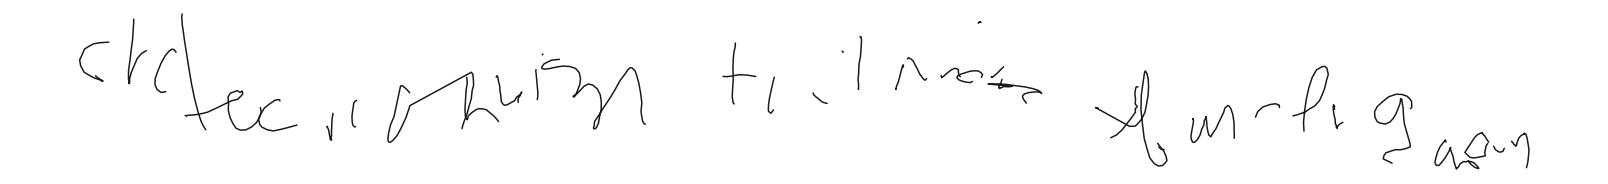

In [108]:
idx = 7
plot_stroke(gen_strokes[idx])

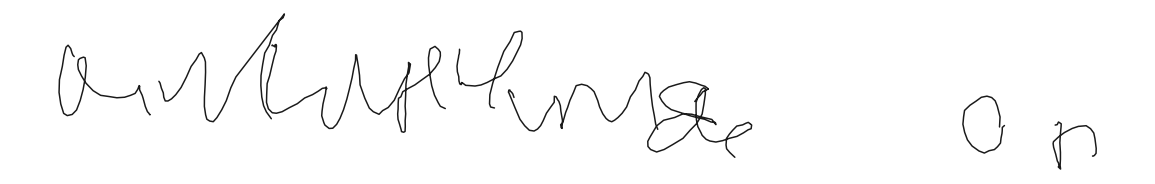

In [119]:
idx = 10
plot_stroke(gen_strokes[idx])

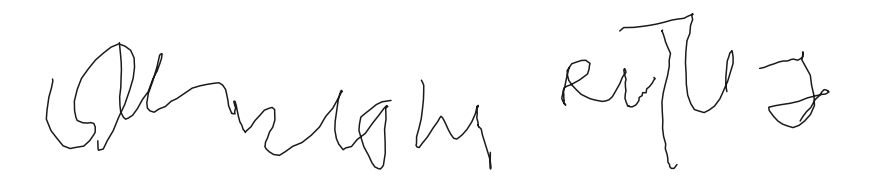

In [84]:
idx = 4
plot_stroke(gen_strokes[idx])

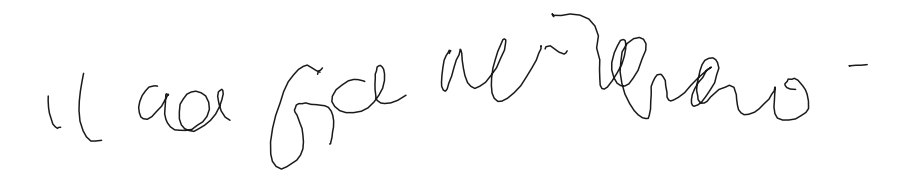

In [85]:
idx = 5
plot_stroke(gen_strokes[idx])

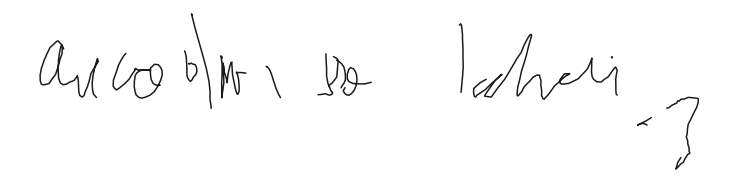

In [86]:
idx = 6
plot_stroke(gen_strokes[idx])

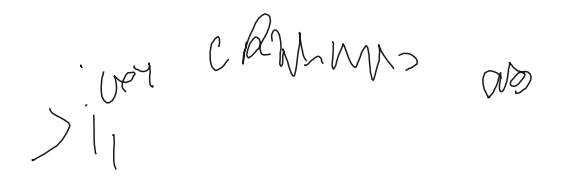

In [87]:
idx = 8
plot_stroke(gen_strokes[idx])

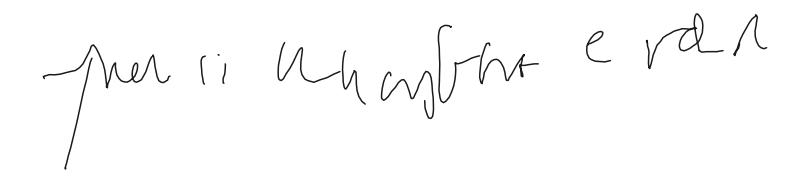

In [88]:
idx = 11
plot_stroke(gen_strokes[idx])

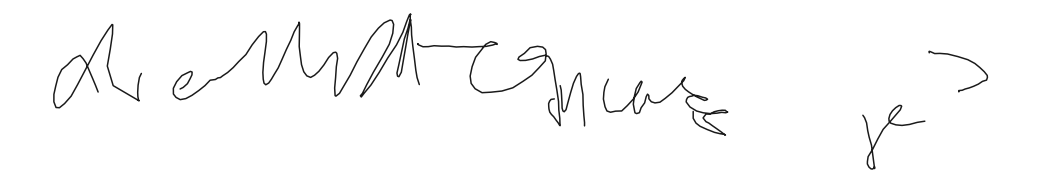

In [89]:
idx = 12
plot_stroke(gen_strokes[idx])

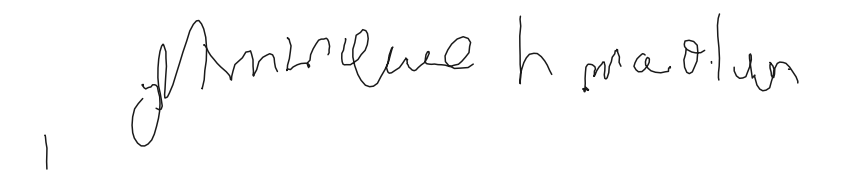

In [90]:
idx = 13
plot_stroke(gen_strokes[idx])

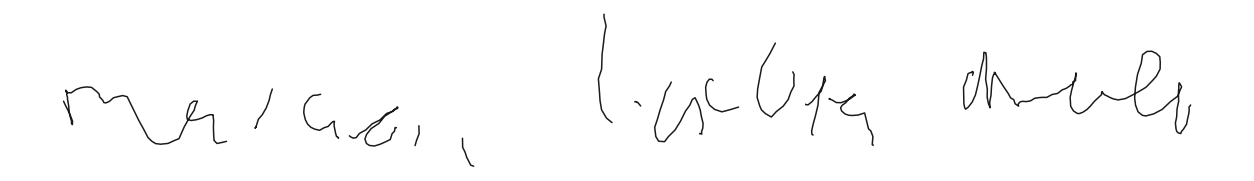

In [91]:
idx = 16
plot_stroke(gen_strokes[idx])

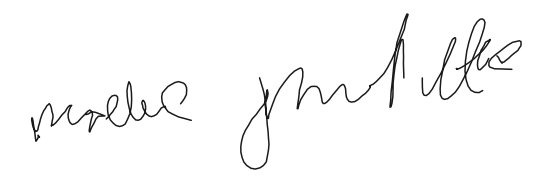

In [92]:
idx = 19
plot_stroke(gen_strokes[idx])

In [ ]:
for i in range(20):
    plot_stro